## Production Forecasting - ML Modeling

In this notebook, a model was developed and validated in time to history match the wells. The developed model can be used to forecast production for any desired length of time.

In [5]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

In [21]:
#Import data and rearrange feature/target columns

data = pd.read_csv(r'novi_data_prep2.csv', index_col=0)
cols = [i for i in data.columns if i != 'novi_oil'] + ['novi_oil']
data = data[cols]
data

,novi_unique_key,novi_ip_day,novi_bottom_hole_latitude,novi_bottom_hole_longitude,novi_brittleness,novi_current_operator,novi_date,novi_formation,novi_frac_date,novi_heel_latitude,novi_heel_longitude,novi_lateral_length,novi_permeability,novi_porosity,novi_net_thickness,novi_region,novi_spacing_azimuth,novi_spacing_is_child,novi_spacing_wells_in_radius,novi_surface_hole_latitude,novi_surface_hole_longitude,novi_sw,novi_toc,novi_total_fluid,novi_total_proppant,novi_tvd,novi_vclay,novi_permeability_log,novi_current_operator_grouped,novi_formation_Middle Bakken,novi_formation_Three Forks,novi_formation_Unknown,novi_region_Mountrail,novi_region_Unknown,novi_region_Williams,novi_spacing_is_child_True,novi_spacing_is_child_False,novi_current_operator_grouped_Whiting,novi_current_operator_grouped_EOG,novi_current_operator_grouped_Hess,novi_current_operator_grouped_Others,novi_current_operator_grouped_Oasis,novi_current_operator_grouped_Continental Resources,novi_kh,novi_shut_in_days,novi_cum_shut_in_days,novi_cum_oil_days,novi_well_age,novi_oil
0,33061005990000,1,48.012837,-102.380303,65.915598,Whiting,2008-06-13,Middle Bakken,2008-06-28,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,Mountrail,-64.659417,True,2.0,48.02246,-102.40635,0.458193,2.615370,0.000000,1840000.0,9956.671233,0.168064,-4.085969,Whiting,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0.350546,0.0,0.0,1,1.0,0.000000
1,33061005990000,30,48.012837,-102.380303,65.915598,Whiting,2008-07-27,Middle Bakken,2008-06-28,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,Mountrail,-64.659417,True,2.0,48.02246,-102.40635,0.458193,2.615370,0.000000,1840000.0,9956.671233,0.168064,-4.085969,Whiting,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0.350546,15.0,15.0,31,46.0,858.629032
2,33061005990000,60,48.012837,-102.380303,65.915598,Whiting,2008-08-26,Middle Bakken,2008-06-28,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,Mountrail,-64.659417,True,2.0,48.02246,-102.40635,0.458193,2.615370,0.000000,1840000.0,9956.671233,0.168064,-4.085969,Whiting,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0.350546,0.0,15.0,91,91.0,566.890323
3,33061005990000,90,48.012837,-102.380303,65.915598,Whiting,2008-09-25,Middle Bakken,2008-06-28,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,Mountrail,-64.659417,True,2.0,48.02246,-102.40635,0.458193,2.615370,0.000000,1840000.0,9956.671233,0.168064,-4.085969,Whiting,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0.350546,0.0,15.0,181,181.0,434.219534
4,33061005990000,120,48.012837,-102.380303,65.915598,Whiting,2008-10-25,Middle Bakken,2008-06-28,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,Mountrail,-64.659417,True,2.0,48.02246,-102.40635,0.458193,2.615370,0.000000,1840000.0,9956.671233,0.168064,-4.085969,Whiting,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0.350546,0.0,15.0,301,301.0,378.454659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49529,33105053950000,90,48.007990,-103.837793,61.792741,Nine Point Energy,2021-03-31,Middle Bakken,1800-01-01,48.00781,-103.87183,12423.000000,0.084485,0.063256,17.423451,Williams,88.697271,True,5.0,48.01421,-103.87551,0.401387,3.053981,231479.833333,11833155.0,10396.521739,0.176241,-2.471177,Others,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1.472027,0.0,0.0,181,181.0,527.709677
49530,33105053950000,120,48.007990,-103.837793,61.792741,Nine Point Energy,2021-04-30,Middle Bakken,1800-01-01,48.00781,-103.87183,12423.000000,0.084485,0.063256,17.423451,Williams,88.697271,True,5.0,48.01421,-103.87551,0.401387,3.053981,231479.833333,11833155.0,10396.521739,0.176241,-2.471177,Others,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1.472027,0.0,0.0,301,301.0,678.200000
49531,33105053950000,150,48.007990,-103.837793,61.792741,Nine Point Energy,2021-05-30,Middle Bakken,1800-01-01,48.00781,-103.87183,12423.000000,0.084485,0.063256,17.423451,Williams,88.697271,True,5.0,48.01421,-103.87551,0.401387,3.053981,231479.833333,11833155.0,10396.521739,

#### Drop unwanted columns - date columns and already encoded features

In [22]:
cols_to_drop = ['novi_region',
                'novi_spacing_is_child',
                'novi_current_operator',
                'novi_formation',
                'novi_current_operator_grouped',
                'novi_spacing_is_child_False',
               'novi_frac_date']
data.drop(cols_to_drop, axis=1, inplace=True)

#### Prepare Well Data for Modeling

In [23]:
dynamic_features = ['novi_ip_day', 
                    'novi_shut_in_days', 'novi_cum_shut_in_days', 
                    'novi_cum_oil_days', 'novi_well_age', 
                    'novi_oil']

well_id_col = 'novi_unique_key'
date_col = 'novi_date'  #'novi_ip_day'
lookback = 1     # number of months (time periods) of well history to use in following month forecast 

In [24]:
def prep_well_history(well_df, dynamic_features, 
                      well_id_col, time_index_col, forecast_length=1, history_length=2):
    '''
    Function collects well historical dynamic information at each timestep
    and maps it to oil production at current time step.
    history length is the number of lookback timesteps to use in predicting 
    the target variable at current timestep.
    '''
    well_time_id_cols = [well_id_col, time_index_col]
    well_time_index_df = well_df[well_time_id_cols]
    df_history = well_df[dynamic_features]
    df_forecast = well_df.drop(well_time_id_cols, axis=1) 
    df_history_cols = df_history.columns
    df_forecast_cols = df_forecast.columns
    dfs, col_names = [well_time_index_df], well_time_id_cols
    # well history timesteps (t-n, ... t-1
    for i in range(history_length, 0, -1):
        dfs.append(df_history.shift(i))
        col_names += [('{}(t-{})'.format(col,i)) for col in df_history_cols]
    # well forecast timestep (t)
    for i in range(0, forecast_length):
        dfs.append(df_forecast.shift(-i))
        name = ['{}(t)'.format(col) for col in df_forecast_cols]
        col_names.extend(name)
    df_data = pd.concat(dfs, axis=1)
    df_data.columns = col_names
    return df_data

In [25]:
wells_list = data['novi_unique_key'].unique()

final_data = []
for well in wells_list:
    well_df = data[data['novi_unique_key'] == well]
    well_data = prep_well_history(well_df, dynamic_features, well_id_col, 
                           date_col, history_length=lookback)
    final_data.append(well_data)
    
final_data_df = pd.concat(final_data)
final_data_df.dropna(inplace=True)
final_data_df.head()

,novi_unique_key,novi_date,novi_ip_day(t-1),novi_shut_in_days(t-1),novi_cum_shut_in_days(t-1),novi_cum_oil_days(t-1),novi_well_age(t-1),novi_oil(t-1),novi_ip_day(t),novi_bottom_hole_latitude(t),novi_bottom_hole_longitude(t),novi_brittleness(t),novi_heel_latitude(t),novi_heel_longitude(t),novi_lateral_length(t),novi_permeability(t),novi_porosity(t),novi_net_thickness(t),novi_spacing_azimuth(t),novi_spacing_wells_in_radius(t),novi_surface_hole_latitude(t),novi_surface_hole_longitude(t),novi_sw(t),novi_toc(t),novi_total_fluid(t),novi_total_proppant(t),novi_tvd(t),novi_vclay(t),novi_permeability_log(t),novi_formation_Middle Bakken(t),novi_formation_Three Forks(t),novi_formation_Unknown(t),novi_region_Mountrail(t),novi_region_Unknown(t),novi_region_Williams(t),novi_spacing_is_child_True(t),novi_current_operator_grouped_Whiting(t),novi_current_operator_grouped_EOG(t),novi_current_operator_grouped_Hess(t),novi_current_operator_grouped_Others(t),novi_current_operator_grouped_Oasis(t),novi_current_operator_grouped_Continental Resources(t),novi_kh(t),novi_shut_in_days(t),novi_cum_shut_in_days(t),novi_cum_oil_days(t),novi_well_age(t),novi_oil(t)
1,33061005990000,2008-07-27,1.0,0.0,0.0,1.0,1.0,0.000000,30,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.61537,0.0,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,15.0,15.0,31,46.0,858.629032
2,33061005990000,2008-08-26,30.0,15.0,15.0,31.0,46.0,858.629032,60,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.61537,0.0,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,0.0,15.0,91,91.0,566.890323
3,33061005990000,2008-09-25,60.0,0.0,15.0,91.0,91.0,566.890323,90,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.61537,0.0,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,0.0,15.0,181,181.0,434.219534
4,33061005990000,2008-10-25,90.0,0.0,15.0,181.0,181.0,434.219534,120,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.61537,0.0,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,0.0,15.0,301,301.0,378.454659
5,33061005990000,2008-11-24,120.0,0.0,15.0,301.0,301.0,378.454659,150,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.61537,0.0,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,0.0,15.0,451,451.0,324.553118


In [11]:
final_data_df.shape

(46810, 48)

### Feature Selection

#### Checking Feautre Correlation

In [26]:
final_data_df.iloc[:,2:].corr()['novi_oil(t)'].sort_values()

novi_ip_day(t)                                           -0.545729
novi_ip_day(t-1)                                         -0.545662
novi_cum_oil_days(t)                                     -0.378751
novi_well_age(t)                                         -0.378712
novi_cum_oil_days(t-1)                                   -0.374187
novi_well_age(t-1)                                       -0.374152
novi_cum_shut_in_days(t-1)                               -0.321506
novi_cum_shut_in_days(t)                                 -0.303562
novi_surface_hole_latitude(t)                            -0.135103
novi_heel_latitude(t)                                    -0.134895
novi_bottom_hole_latitude(t)                             -0.130627
novi_current_operator_grouped_Hess(t)                    -0.074799
novi_current_operator_grouped_Whiting(t)                 -0.050660
novi_vclay(t)                                            -0.050174
novi_porosity(t)                                         -0.04

In [27]:
# Taking absolute value of correlation
abs(final_data_df.iloc[:,2:].corr()['novi_oil(t)']).sort_values()

novi_bottom_hole_longitude(t)                             0.001751
novi_heel_longitude(t)                                    0.003188
novi_surface_hole_longitude(t)                            0.003426
novi_region_Unknown(t)                                    0.003798
novi_toc(t)                                               0.008758
novi_spacing_is_child_True(t)                             0.010682
novi_current_operator_grouped_Oasis(t)                    0.016402
novi_current_operator_grouped_EOG(t)                      0.023109
novi_permeability_log(t)                                  0.025865
novi_formation_Middle Bakken(t)                           0.026263
novi_sw(t)                                                0.026507
novi_formation_Unknown(t)                                 0.026959
novi_brittleness(t)                                       0.027765
novi_formation_Three Forks(t)                             0.029700
novi_permeability(t)                                      0.03

In the interest of time, a model-building-based feature selection approach will be employed. Due to this fact, a learning algorithm (XGBoost) that allows for feature selection through feature importance will be used for model development.

### Model Building

In [28]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

#### Drop forecast period features that could cause data leakage

In [29]:
cols_to_drop = ['novi_cum_oil_days(t)', 'novi_shut_in_days(t)']
final_data_df.drop(cols_to_drop, axis=1, inplace=True)
final_data_df.head(5)

,novi_unique_key,novi_date,novi_ip_day(t-1),novi_shut_in_days(t-1),novi_cum_shut_in_days(t-1),novi_cum_oil_days(t-1),novi_well_age(t-1),novi_oil(t-1),novi_ip_day(t),novi_bottom_hole_latitude(t),novi_bottom_hole_longitude(t),novi_brittleness(t),novi_heel_latitude(t),novi_heel_longitude(t),novi_lateral_length(t),novi_permeability(t),novi_porosity(t),novi_net_thickness(t),novi_spacing_azimuth(t),novi_spacing_wells_in_radius(t),novi_surface_hole_latitude(t),novi_surface_hole_longitude(t),novi_sw(t),novi_toc(t),novi_total_fluid(t),novi_total_proppant(t),novi_tvd(t),novi_vclay(t),novi_permeability_log(t),novi_formation_Middle Bakken(t),novi_formation_Three Forks(t),novi_formation_Unknown(t),novi_region_Mountrail(t),novi_region_Unknown(t),novi_region_Williams(t),novi_spacing_is_child_True(t),novi_current_operator_grouped_Whiting(t),novi_current_operator_grouped_EOG(t),novi_current_operator_grouped_Hess(t),novi_current_operator_grouped_Others(t),novi_current_operator_grouped_Oasis(t),novi_current_operator_grouped_Continental Resources(t),novi_kh(t),novi_cum_shut_in_days(t),novi_well_age(t),novi_oil(t)
1,33061005990000,2008-07-27,1.0,0.0,0.0,1.0,1.0,0.000000,30,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.61537,0.0,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,15.0,46.0,858.629032
2,33061005990000,2008-08-26,30.0,15.0,15.0,31.0,46.0,858.629032,60,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.61537,0.0,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,15.0,91.0,566.890323
3,33061005990000,2008-09-25,60.0,0.0,15.0,91.0,91.0,566.890323,90,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.61537,0.0,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,15.0,181.0,434.219534
4,33061005990000,2008-10-25,90.0,0.0,15.0,181.0,181.0,434.219534,120,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.61537,0.0,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,15.0,301.0,378.454659
5,33061005990000,2008-11-24,120.0,0.0,15.0,301.0,301.0,378.454659,150,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.61537,0.0,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,15.0,451.0,324.553118


#### Quick check to decide a proper cut-off date to Split data for model validation

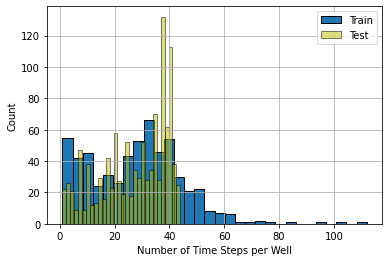

In [30]:
# Making sure that cut-off date allows for enough timesteps/well for model validation with Test Data
cut_off_date = '2018-01-01'
train = final_data_df[final_data_df['novi_date'] < cut_off_date]
test = final_data_df[final_data_df['novi_date'] >= cut_off_date]
train_wells = train['novi_unique_key'].nunique()
test_wells = test['novi_unique_key'].nunique()

time_index_counts_train = train.groupby('novi_unique_key')['novi_date'].count()
time_index_counts_test = test.groupby('novi_unique_key')['novi_date'].count()

min_count_train = time_index_counts_train.min()
max_count_train = time_index_counts_train.max()
time_index_counts_train.hist(bins=30,label='Train', edgecolor='k')
ax = time_index_counts_test.hist(bins=30, alpha=0.5, color='y', label='Test', edgecolor='k')
ax.set_xlabel("Number of Time Steps per Well")
ax.set_ylabel("Count")
ax.legend()

#### Perform Data Split

In [31]:
target = 'novi_oil(t)'
index_cols = ['novi_unique_key', 'novi_date',]
input_features = [col for col in final_data_df.columns if col not in index_cols+[target]]

# Split for Validation in Time
train_data =  final_data_df[final_data_df['novi_date'] < cut_off_date]
test_data = final_data_df[final_data_df['novi_date'] >= cut_off_date]

X_train, y_train = train_data[input_features], train_data[target]
X_test, y_test = test_data[input_features], test_data[target]

# Normalize the data for training & Testing
x_scaler = MinMaxScaler()
x_scaler.fit(X_train)
X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_scaler = MinMaxScaler()
y_scaler.fit(y_train.values.reshape(-1,1))
y_train_scaled = y_scaler.transform(y_train.values.reshape(-1,1))

In [32]:
# Checking that we have the right data types
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16153 entries, 1 to 44842
Data columns (total 43 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   novi_ip_day(t-1)                                        16153 non-null  float64
 1   novi_shut_in_days(t-1)                                  16153 non-null  float64
 2   novi_cum_shut_in_days(t-1)                              16153 non-null  float64
 3   novi_cum_oil_days(t-1)                                  16153 non-null  float64
 4   novi_well_age(t-1)                                      16153 non-null  float64
 5   novi_oil(t-1)                                           16153 non-null  float64
 6   novi_ip_day(t)                                          16153 non-null  int64  
 7   novi_bottom_hole_latitude(t)                            16153 non-null  float64
 8   novi_bottom_hole_longitude(t)       

In [33]:
len(y_train), len(y_test)

(16153, 30657)

#### Train & Validate ML Model

In [35]:
xgb_model = XGBRegressor(n_estimators=8, max_depth=10, learning_rate=0.5)

cv_folds=5
early_stopping_rounds=50
xgb_param = xgb_model.get_xgb_params()
xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb_model.get_params()['n_estimators'], 
                  nfold=cv_folds, metrics='rmse', early_stopping_rounds=early_stopping_rounds)

xgb_model.set_params(n_estimators=cvresult.shape[0])
    
#Fit the algorithm on the data
xgb_model.fit(X_train_scaled, y_train_scaled)#, eval_metric='rmse')


# Score on training set:
train_predictions = xgb_model.predict(X_train_scaled)
train_pred_unscaled = y_scaler.inverse_transform(train_predictions.reshape(-1,1))

# Score on test set:
test_predictions = xgb_model.predict(X_test_scaled)
test_pred_unscaled = y_scaler.inverse_transform(test_predictions.reshape(-1,1))

print('model report:')
print("\n")
print("R2_Train : {}".format(r2_score(y_train, train_pred_unscaled)))
print("RMSE_Train : {}".format(mean_squared_error(y_train, train_pred_unscaled)**0.5))
print("\n")

print("R2_Test : {}".format(r2_score(y_test, test_pred_unscaled)))
print("RMSE_Test : {}".format(mean_squared_error(y_test, test_pred_unscaled)**0.5))

importances = xgb_model.feature_importances_
feature_importance = pd.DataFrame.from_dict(dict(zip(input_features, importances)),  
                                            orient='index', columns=['Importance'])
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance

model report:


R2_Train : 0.9806536866313251
RMSE_Train : 25.487786702290528


R2_Test : 0.8070277505146024
RMSE_Test : 105.89564385657596


,Importance
novi_well_age(t),0.490475
novi_oil(t-1),0.135187
novi_well_age(t-1),0.075841
novi_current_operator_grouped_Whiting(t),0.042515
novi_surface_hole_latitude(t),0.022821
novi_sw(t),0.019345
novi_total_proppant(t),0.017867
novi_heel_latitude(t),0.013685
novi_kh(t),0.013057
novi_total_fluid(t),0.012257


#### Feature Selection

Top important features could be selected based on the feature importance output.

#### Save Model and Scaler Objects

In [36]:
import pickle
xgb_model.save_model(r'model.pkl')
pickle.dump(x_scaler, open('x_scaler.pkl', 'wb'))
pickle.dump(y_scaler, open('y_scaler.pkl', 'wb'))

c:\Users\mjalabboodi.HS\Anaconda3\envs\ai_tools\lib\site-packages\xgboost\core.py:158: UserWarning: [16:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


#### Production History Matching - Score Model on Entire Dataset (Train and Test Period)

In [37]:
deploy_data = final_data_df[["novi_unique_key","novi_date"] + input_features  +[target]]
deploy_data['novi_date'] = pd.to_datetime(deploy_data['novi_date'])
deploy_data

,novi_unique_key,novi_date,novi_ip_day(t-1),novi_shut_in_days(t-1),novi_cum_shut_in_days(t-1),novi_cum_oil_days(t-1),novi_well_age(t-1),novi_oil(t-1),novi_ip_day(t),novi_bottom_hole_latitude(t),novi_bottom_hole_longitude(t),novi_brittleness(t),novi_heel_latitude(t),novi_heel_longitude(t),novi_lateral_length(t),novi_permeability(t),novi_porosity(t),novi_net_thickness(t),novi_spacing_azimuth(t),novi_spacing_wells_in_radius(t),novi_surface_hole_latitude(t),novi_surface_hole_longitude(t),novi_sw(t),novi_toc(t),novi_total_fluid(t),novi_total_proppant(t),novi_tvd(t),novi_vclay(t),novi_permeability_log(t),novi_formation_Middle Bakken(t),novi_formation_Three Forks(t),novi_formation_Unknown(t),novi_region_Mountrail(t),novi_region_Unknown(t),novi_region_Williams(t),novi_spacing_is_child_True(t),novi_current_operator_grouped_Whiting(t),novi_current_operator_grouped_EOG(t),novi_current_operator_grouped_Hess(t),novi_current_operator_grouped_Others(t),novi_current_operator_grouped_Oasis(t),novi_current_operator_grouped_Continental Resources(t),novi_kh(t),novi_cum_shut_in_days(t),novi_well_age(t),novi_oil(t)
1,33061005990000,2008-07-27,1.0,0.0,0.0,1.0,1.0,0.000000,30,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.615370,0.000000,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,15.0,46.0,858.629032
2,33061005990000,2008-08-26,30.0,15.0,15.0,31.0,46.0,858.629032,60,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.615370,0.000000,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,15.0,91.0,566.890323
3,33061005990000,2008-09-25,60.0,0.0,15.0,91.0,91.0,566.890323,90,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.615370,0.000000,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,15.0,181.0,434.219534
4,33061005990000,2008-10-25,90.0,0.0,15.0,181.0,181.0,434.219534,120,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.615370,0.000000,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,15.0,301.0,378.454659
5,33061005990000,2008-11-24,120.0,0.0,15.0,301.0,301.0,378.454659,150,48.012837,-102.380303,65.915598,48.02116,-102.40436,9297.666667,0.016807,0.053066,20.857313,-64.659417,2.0,48.02246,-102.40635,0.458193,2.615370,0.000000,1840000.0,9956.671233,0.168064,-4.085969,1,0,0,1,0,0,1,1,0,0,0,0,0,0.350546,15.0,451.0,324.553118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49529,33105053950000,2021-03-31,60.0,0.0,0.0,91.0,91.0,703.417204,90,48.007990,-103.837793,61.792741,48.00781,-103.87183,12423.000000,0.084485,0.063256,17.423451,88.697271,5.0,48.01421,-103.87551,0.401387,3.053981,231479.833333,11833155.0,10396.521739,0.176241,-2.471177,1,0,0,0,0,1,1,0,0,0,1,0,0,1.472027,0.0,181.0,527.709677
49530,33105053950000,2021-04-30,90.0,0.0,0.0,181.0,181.0,527.709677,120,48.007990,-103.837793,61.792741,48.00781,-103.87183,12423.000000,0.084485,0.063256,17.423451,88.697271,5.0,48.01421,-103.87551,0.401387,3.053981,231479.833333,11833155.0,10396.521739,0.176241,-2.471177,1,0,0,0,0,1,1,0,0,0,1,0,0,1.472027,0.0,301.0,678.200000
49531,33105053950000,2021-05-30,120.0,0.0,0.0,301.0,301.0,678.200000,150,48.007990,-103.837793,61.792741,48.00781,-103.87183,12423.000000,0.084485,0.063256,17.423451,88.697271,5.0,48.01421,-103.87551,0.401387,3.053981,231479.833333,11833155.0,10396.521739,0.176241,-2.471177,1,0,0,0,0,1,1,0,0,0,1,0,0,1.472027,0.0,451.0,669.161290
49532,33105053950000,2021-06-29,150.0,0.0,0.0,451.0,451.0,669.161290,180,48.007990,-103.837793,61.792741,48.00781,-103.8718

In [38]:
scaled_data = x_scaler.transform(deploy_data[input_features])
predicted_unscaled = xgb_model.predict(scaled_data)
novi_oil_pred = y_scaler.inverse_transform(predicted_unscaled.reshape(-1,1))
deploy_data['novi_oil_pred'] = novi_oil_pred

In [41]:
plot_data['novi_unique_key'].unique()[0:10]

array([33061005990000, 33061007120000, 33061007560000, 33061015420000,
       33061015870000, 33061016180000, 33061016300000, 33061016310000,
       33061016570000, 33061016620000], dtype=int64)

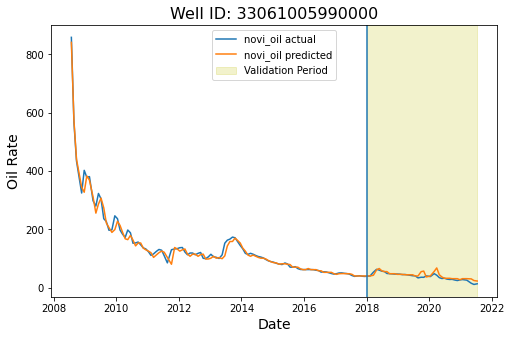

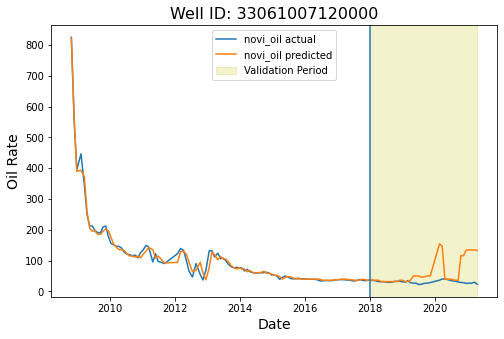

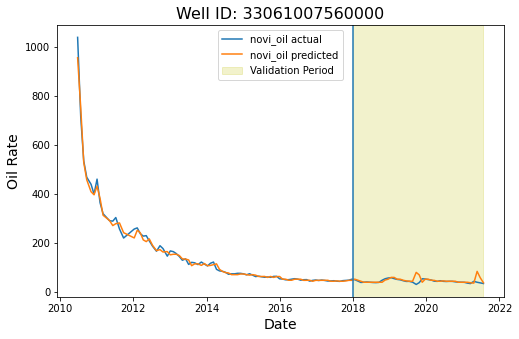

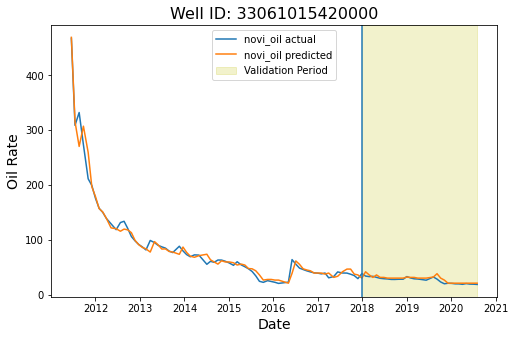

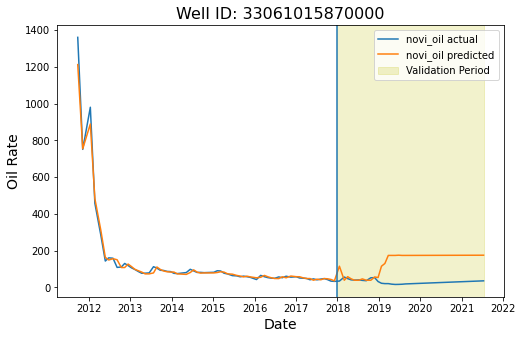

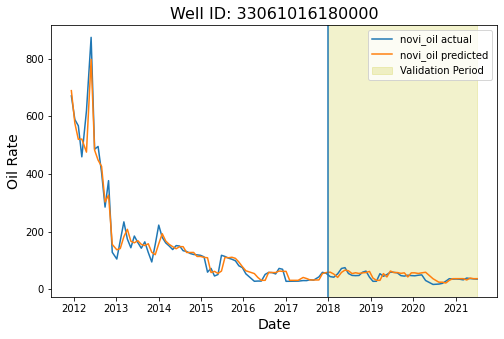

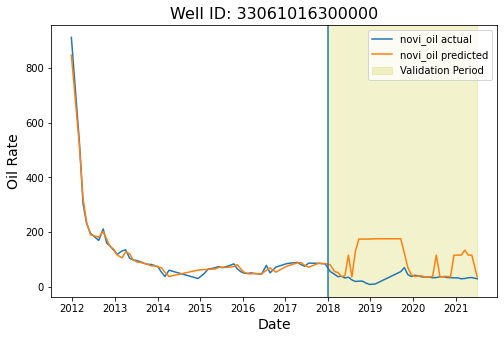

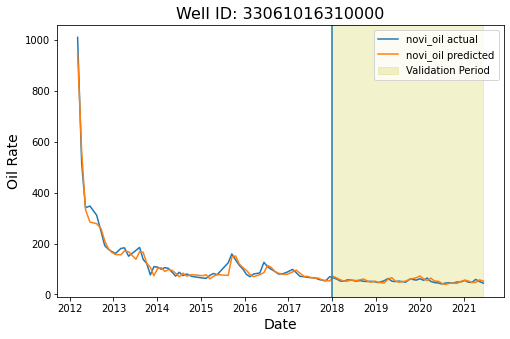

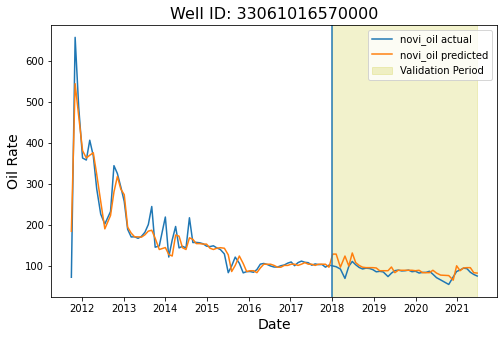

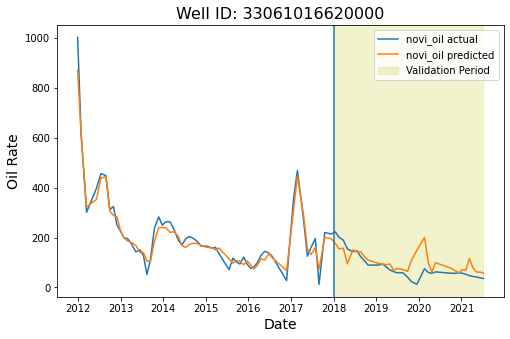

In [42]:
plot_data = deploy_data[['novi_unique_key', 'novi_date', 'novi_oil(t)', 'novi_oil_pred']]

for well in plot_data['novi_unique_key'].unique()[0:10]:
    well_data = plot_data[plot_data['novi_unique_key']==well]
    end_dt = well_data['novi_date'].max()
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    ax.plot(well_data['novi_date'], well_data['novi_oil(t)'], label='novi_oil actual')
    ax.plot(well_data['novi_date'], well_data['novi_oil_pred'], label='novi_oil predicted')
    plt.axvline(pd.to_datetime(cut_off_date))
    ax.axvspan(pd.to_datetime(cut_off_date), end_dt, color='y', alpha=0.2, label='Validation Period')
    ax.set_ylabel('Oil Rate', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_title(f'Well ID: {well}', fontsize=16)
    ax.legend()
    #plt.savefig(r'./Production_Forecasting_ML_Model_Plots/Well_{}.png'.format(well), dpi=300)

#### Production Forecasting

As a next step, the model could be used for forecasting beyond the test period. There are various approaches to perform this!

### Production Forecasting - Decline Curve Analysis vs. Machine Learning Approach

In this first part of this assignment, oil production forecasting was performed using decline curve analysis, a traditional approach that has been used in the Petroleum Industry for many decades. Specifically, the Arps model which has been widely used for forecasting in conventional reservoirs was used in part 1 of this project. Decline curve analysis is a parametric approach which involves fitting hydrocarbon production to a pre-determined model. While the Arps model has three major decline curve profiles, there are other models such as the Duong Model and Stretched Exponential Decline Model which have been developed for production in unconventional reservoirs. These models have been developed using empirical production data. The downside to this approach is that it is difficult to know before hand which model will fit a well's production profile, especially in unconvetional wells. Production from oil and gas wells is controlled by a complex relationship of many factors including but not limited to geologic characteristics of the formation, dynamic factors such as production or injection from offset wells, well completion and so on.
The second part of this project uses a data-driven approach with machine learning to perform Production forecasting. The machine learning aproach allows to not only incorporate the production history of the well(s) in a reservoir, it allows to also use every other information available about the well as input into forecasting the production from these wells. A machine learning model is better able to capture the impact of factors such as shut-in period, offset well information and the likes on future production from the well(s).